In [5]:
# !pip install torchsummary
# !pip install cca-zoo[deep]
# !pip install multiviewdata
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import itertools
from matplotlib import image
import glob as glob
from PIL import Image
import cca_zoo

from multiviewdata.torchdatasets import SplitMNIST, NoisyMNIST
from torch.utils.data import Subset
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

# print("PyTorch Version: ",torch.__version__)
# print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
  print("Using the GPU!")
else:
  print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")


In [6]:
def get_dataloaders(
        dataset,
        val_dataset=None,
        batch_size=None,
        val_batch_size=None,
        drop_last=True,
        val_drop_last=False,
        shuffle_train=False,
        pin_memory=True,
        num_workers=0,
        persistent_workers=True,
):
    """
    A utility function to allow users to quickly get hold of the dataloaders required by pytorch lightning
    :param dataset: A CCA dataset used for training
    :param val_dataset: An optional CCA dataset used for validation
    :param batch_size: batch size of train loader
    :param val_batch_size: batch size of val loader
    :param num_workers: number of workers used
    :param pin_memory: pin memory used by pytorch - True tends to speed up training
    :param shuffle_train: whether to shuffle training data
    :param val_drop_last: whether to drop the last incomplete batch from the validation data
    :param drop_last: whether to drop the last incomplete batch from the train data
    :param persistent_workers: whether to keep workers alive after dataloader is destroyed
    """
    if num_workers == 0:
        persistent_workers = False
    if batch_size is None:
        batch_size = len(dataset)
    train_dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=shuffle_train,
        persistent_workers=persistent_workers,
    )
    if val_dataset:
        if val_batch_size is None:
            val_batch_size = len(val_dataset)
        val_dataloader = DataLoader(
            val_dataset,
            batch_size=val_batch_size,
            drop_last=val_drop_last,
            num_workers=num_workers,
            pin_memory=pin_memory,
            persistent_workers=persistent_workers,
        )
        return train_dataloader, val_dataloader
    return train_dataloader

In [7]:
from multiviewdata.torchdatasets import SplitMNIST, NoisyMNIST
from torch.utils.data import Subset
import numpy as np

from cca_zoo.data.deep import get_dataloaders


def example_mnist_data(n_train, n_val, batch_size=50, val_batch_size=10, type="split"):
    if type == "split":
        train_dataset = SplitMNIST(
            root="", mnist_type="MNIST", train=True, download=True
        )
    else:
        train_dataset = NoisyMNIST(
            root="", mnist_type="MNIST", train=True, download=True
        )
    # Adding noise to the mnist
    for i in train_dataset:
      noise = np.random.normal(0.0, 0.1, i['views'][1].shape)
      noise = torch.from_numpy(noise)
      noisy_view=list(i['views'])
      noisy_view[1]+=noise
      i['views']=noisy_view

    val_dataset = Subset(train_dataset, np.arange(n_train, n_train + n_val))
    train_dataset = Subset(train_dataset, np.arange(n_train))
    train_loader, val_loader = get_dataloaders(
        train_dataset, val_dataset, batch_size=batch_size, val_batch_size=val_batch_size
    )
    train_labels = train_loader.collate_fn(
        [train_dataset.dataset[idx]["label"] for idx in train_dataset.indices]
    ).numpy()
    return train_loader, val_loader, train_labels

In [10]:
!conda activate base
!export GRPC_PYTHON_BUILD_SYSTEM_OPENSSL=1
!export GRPC_PYTHON_BUILD_SYSTEM_ZLIB=1

!python -m pip install -U lightning


CommandNotFoundError: Your shell has not been properly configured to use 'conda activate'.
To initialize your shell, run

    $ conda init <SHELL_NAME>

Currently supported shells are:
  - bash
  - fish
  - tcsh
  - xonsh
  - zsh
  - powershell

See 'conda init --help' for more information and options.

IMPORTANT: You may need to close and restart your shell after running 'conda init'.




In [8]:
import pytorch_lightning as pl
from matplotlib import pyplot as plt
from cca_zoo import CCA

# %%
from cca_zoo.deepmodels import (
    DCCA,
    DCCA_NOI,
    DCCA_SDL,
    DCCAE,
    BarlowTwins,
)
from cca_zoo.deepmodels import architectures
from cca_zoo.plotting import pairplot_label


# %%
# Data
# -----
LATENT_DIMS = 2
EPOCHS = 100
N_TRAIN = 500
N_VAL = 100

normal_train_loader, normal_val_loader, normal_train_labels = example_mnist_data(N_TRAIN, N_VAL)
encoder_1 = architectures.Encoder(latent_dims=LATENT_DIMS, feature_size=392)
encoder_2 = architectures.Encoder(latent_dims=LATENT_DIMS, feature_size=392)
decoder_1 = architectures.Decoder(latent_dims=LATENT_DIMS, feature_size=392)
decoder_2 = architectures.Decoder(latent_dims=LATENT_DIMS, feature_size=392)

# %%
# Simple CCA
# ----------------------------
latent_dims = 2

train_list = []
X,Y=[],[]
for i in normal_train_loader:
  for j in i['views'][0]:
    X.append(j.numpy())
  for j in i['views'][1]:
    Y.append(j.numpy())
X,Y = np.array(X), np.array(Y)

cca = CCA(latent_dims=latent_dims).fit((X, Y))
cca_result = cca.transform((X, Y))
pairplot_label(cca_result, normal_train_labels, title="Simple CCA")
plt.show()


# %%
# Deep CCA
# ----------------------------
dcca = DCCA(latent_dims=LATENT_DIMS, encoders=[encoder_1, encoder_2])
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    enable_checkpointing=False,
    log_every_n_steps=1,
)

trainer.fit(dcca, normal_train_loader, normal_val_loader)
dcca_multiview_result = dcca.transform(normal_train_loader)
pairplot_label(dcca_multiview_result, normal_train_labels, title="DCCA")
plt.show()



# %%
# Deep CCAE
# ----------------------------
dccae = DCCAE(latent_dims=LATENT_DIMS, encoders=[encoder_1, encoder_2],decoders=[decoder_1,decoder_2])
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    enable_checkpointing=False,
    log_every_n_steps=1,
)

trainer.fit(dccae, normal_train_loader, normal_val_loader)
dccae_multiview_result=dccae.transform(normal_train_loader)
pairplot_label(dccae_multiview_result, normal_train_labels, title="DCCAE")

plt.show()

# %%
# Deep CCA by Barlow Twins
# ----------------------------------------------
barlowtwins = BarlowTwins(latent_dims=LATENT_DIMS, encoders=[encoder_1, encoder_2])
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    enable_checkpointing=False,
    log_every_n_steps=1,
)
trainer.fit(barlowtwins, normal_train_loader, normal_val_loader)
pairplot_label(
    barlowtwins.transform(normal_train_loader), normal_train_labels, title="DCCA by Barlow Twins"
)
plt.show()

ModuleNotFoundError: No module named 'pytorch_lightning'

In [ ]:
batch=next(iter(normal_train_loader))

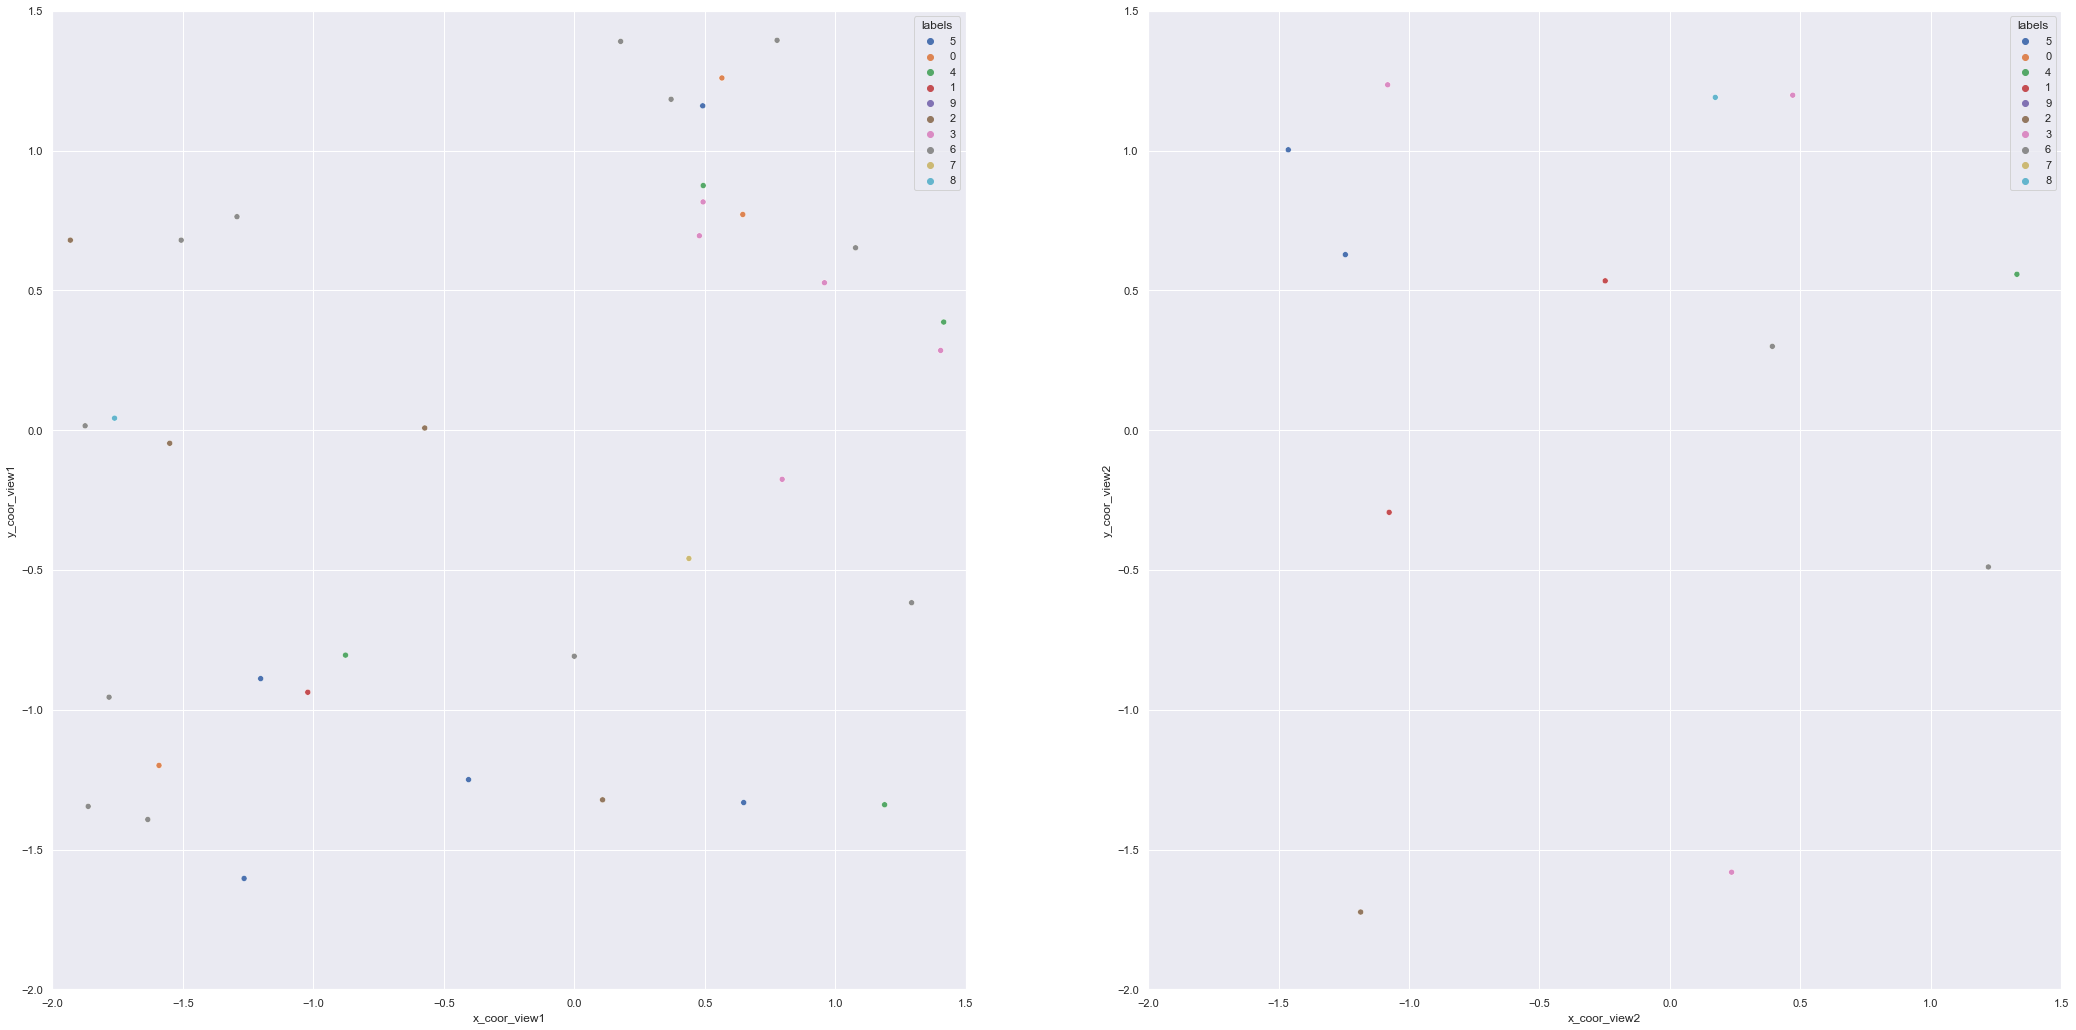

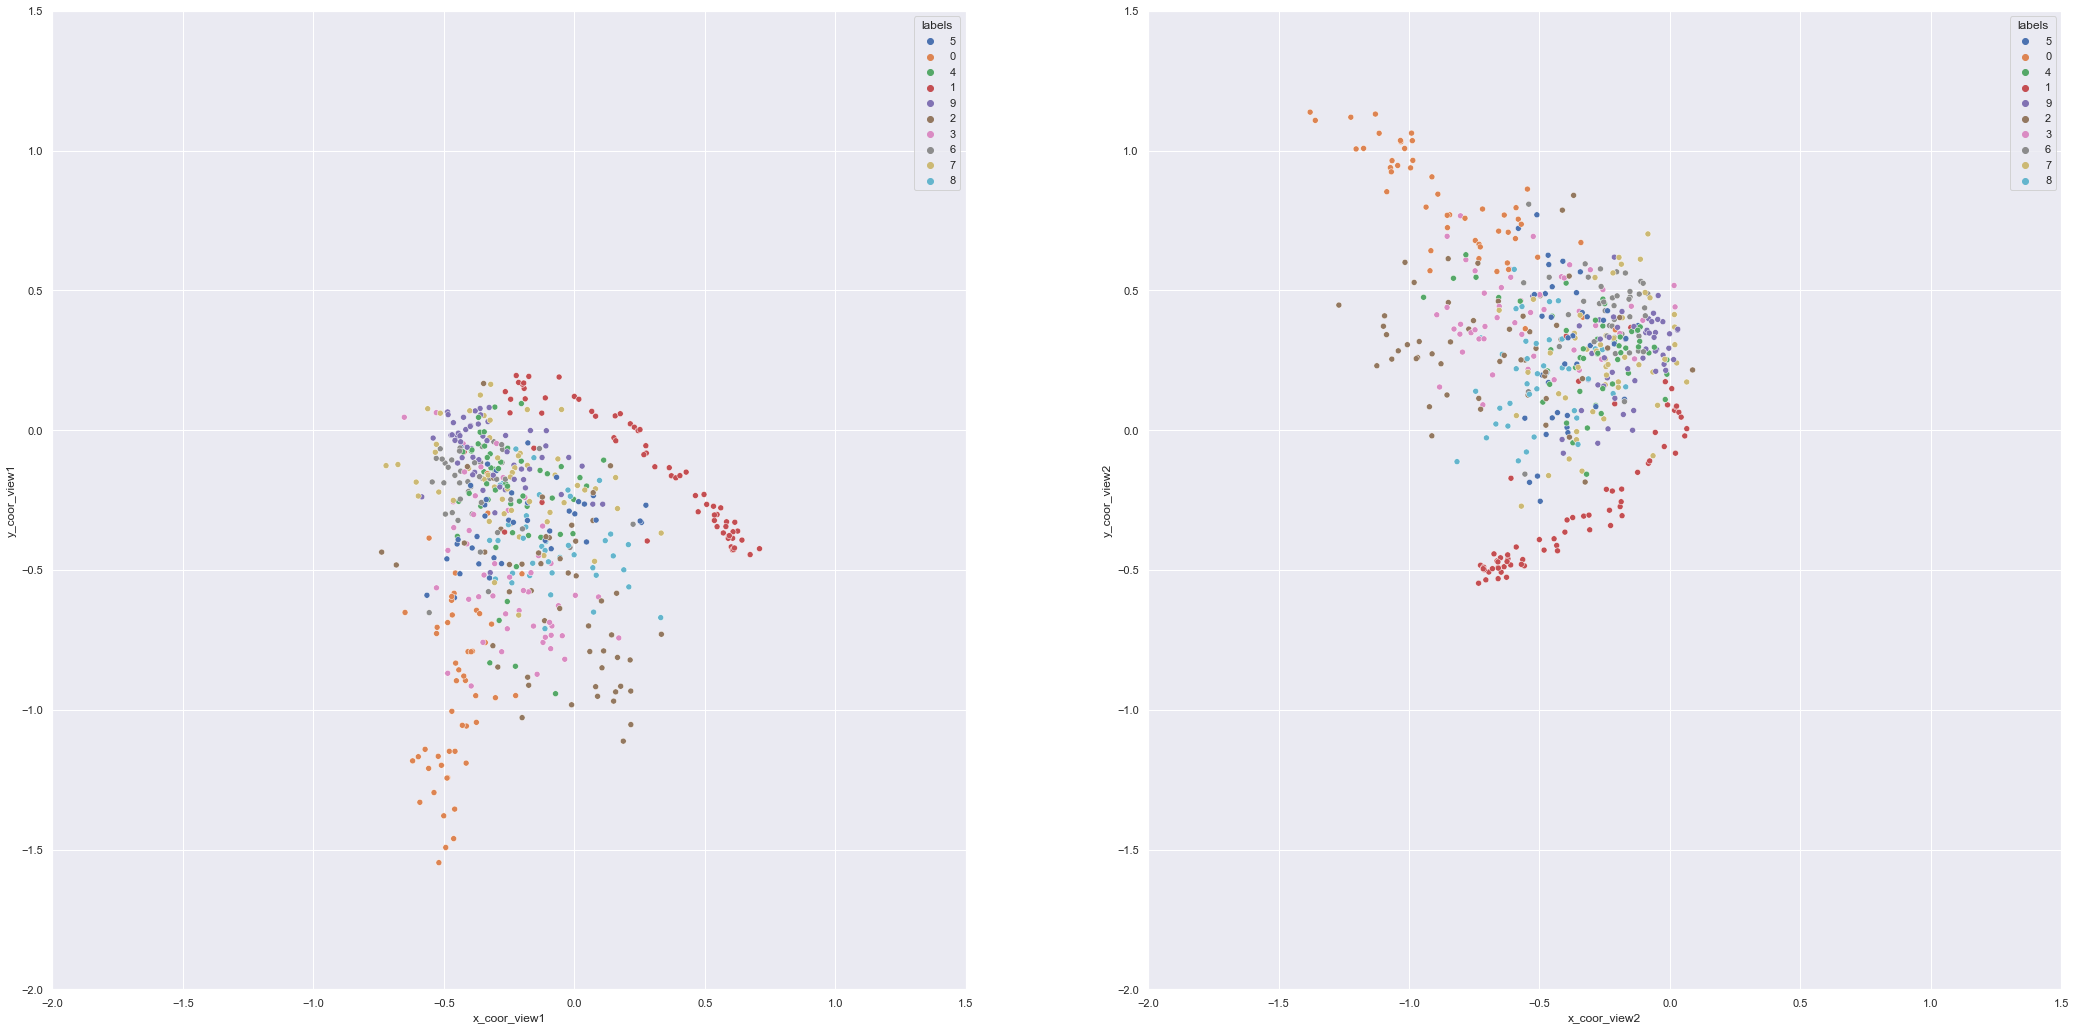

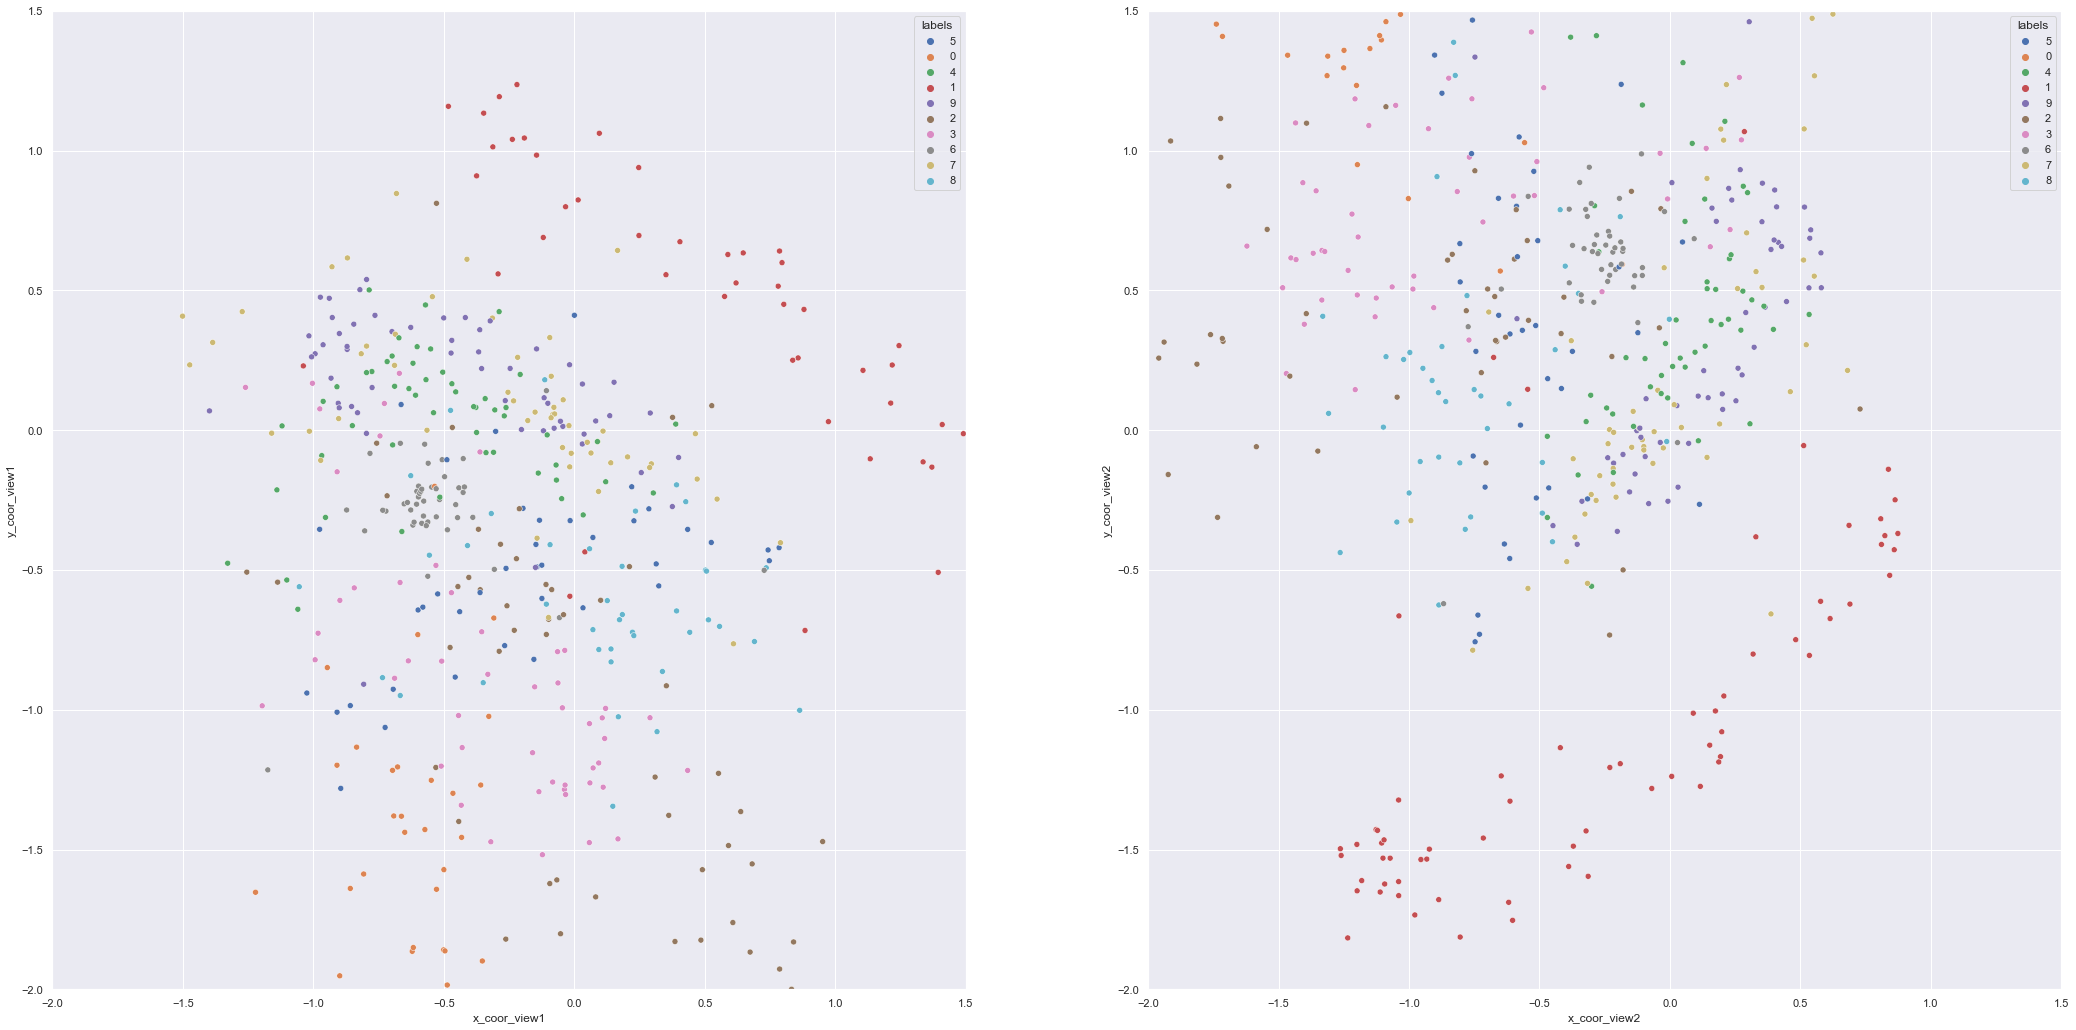

In [ ]:
# Plotting Module
import seaborn as sns
import pandas as pd

def plotting(view_1, view_2, labels):
  # view 1
  view_dict = {"x_coor_view1":[], "y_coor_view1":[],"x_coor_view2":[], "y_coor_view2":[], "labels":[]}
  for point1, point2, label in zip(view_1, view_2, labels):
    view_dict["x_coor_view1"].append(point1[0])
    view_dict["y_coor_view1"].append(point1[1])
    view_dict["x_coor_view2"].append(point2[0])
    view_dict["y_coor_view2"].append(point2[1])
    view_dict["labels"].append(str(label))
  view_df = pd.DataFrame(view_dict)
  sns.set(rc={'figure.figsize':(36,18)})

  #subplot
  f, axes = plt.subplots(1, 2)
  axes[0].set_xlim(-2.0, 1.5)
  axes[0].set_ylim(-2.0, 1.5)
  axes[1].set_xlim(-2.0, 1.5)
  axes[1].set_ylim(-2.0, 1.5)
  sns.scatterplot(data=view_df, x="x_coor_view1", y="y_coor_view1", hue="labels", legend="full", ax=axes[0])
  sns.scatterplot(data=view_df, x="x_coor_view2", y="y_coor_view2", hue="labels", legend="full", ax=axes[1])

view_00, view_01 = cca_result[0], cca_result[1]
view_11, view_12 = dcca_multiview_result[0], dcca_multiview_result[1]
view_21, view_22 = dccae_multiview_result[0], dccae_multiview_result[1]
plotting(view_00, view_01, normal_train_labels)
plotting(view_11, view_12, normal_train_labels)
plotting(view_21, view_22, normal_train_labels)


In [ ]:
# calculating error rate for MNIST

# training SVM
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
linear_svc = svm.LinearSVC()
linear_svc.fit(dcca_multiview_result[:][0][:], normal_train_labels)
#linear_svc.decision_function(dcca_multiview_result[:][0][:])

kfold=KFold(n_splits=10, shuffle=True, random_state=0)
# Simple CCA Score
simple_cca_svc = svm.LinearSVC()
simple_score = cross_val_score(linear_svc, cca_result[:][0][:], normal_train_labels , cv=kfold)
print(sum(simple_score)/10)

# DCCA score
linear_svc = svm.LinearSVC()
linear_scores = cross_val_score(linear_svc,dcca_multiview_result[:][0][:], normal_train_labels , cv=kfold)
print(sum(linear_scores)/10)

# DCCAE score
linear_svc_dccae = svm.LinearSVC()
linear_svc_dccae.fit(dccae_multiview_result[:][0][:], normal_train_labels)
dccae_score = cross_val_score(linear_svc,dccae_multiview_result[:][0][:], normal_train_labels , cv=kfold)
print(sum(dccae_score)/10)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number 

0.32199999999999995
0.38799999999999996
0.37


In [ ]:
# Dataloader
from torchvision import datasets, transforms
import torch

def load_data(data_folder, batch_size, train, num_workers=0, **kwargs):
    transform = {
        'train': transforms.Compose(
            [transforms.Resize([256, 256]),
                transforms.RandomCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])]),
        'test': transforms.Compose(
            [transforms.Resize([224, 224]),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])])
    }
    data = datasets.ImageFolder(root=data_folder, transform=transform['train' if train else 'test'])
    data_loader = get_data_loader(data, batch_size=batch_size, 
                                shuffle=True if train else False, 
                                num_workers=num_workers, **kwargs, drop_last=True if train else False)
    n_class = len(data.classes)

    return data_loader, n_class

def get_data_loader(dataset, batch_size, shuffle=True, drop_last=False, num_workers=0, infinite_data_loader=False, **kwargs):
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=drop_last, num_workers=num_workers, **kwargs)




In [ ]:
# Hazy Image Data
from google.colab import drive
drive.mount('/content/drive')
# Loading Haze Image Dataset
train_loader, n_class = load_data('/content/drive/MyDrive/haze_dataset/ImageNet-18', batch_size=32, train=True)

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
train_features, train_labels = next(iter(train_loader))
print(train_labels)

In [ ]:

from abc import abstractmethod

class _BaseEncoder(torch.nn.Module):
    @abstractmethod
    def __init__(self, latent_dims: int, variational: bool = False):
        super(_BaseEncoder, self).__init__()
        self.variational = variational
        self.latent_dims = latent_dims

    @abstractmethod
    def forward(self, x):
        pass


class Encoder(_BaseEncoder):
    def __init__(
            self,
            latent_dims: int,
            variational: bool = False,
            feature_size: int = 1024,
            layer_sizes: tuple = None,
            activation=nn.LeakyReLU(),
            dropout=0,
    ):
        super(Encoder, self).__init__(latent_dims, variational=variational)
        if layer_sizes is None:
            layer_sizes = (128,)
        layer_sizes = (feature_size,) + layer_sizes + (latent_dims,)
        layers = []
        # other layers
        self.conv1 = torch.nn.Conv2d(1, 32, 5)  # chnl-in, out, krnl
        self.conv2 = torch.nn.Conv2d(32, 64, 5)
        self.pool1 = torch.nn.MaxPool2d(2, stride=2)
        self.pool2 = torch.nn.MaxPool2d(2, stride=2)
        for l_id in range(len(layer_sizes) - 2):
            layers.append(
                torch.nn.Sequential(
                    nn.Dropout(p=dropout),
                    torch.nn.Linear(layer_sizes[l_id], layer_sizes[l_id + 1]),
                    activation,
                )
            )
        self.layers = torch.nn.Sequential(*layers)

        if self.variational:
            self.fc_mu = torch.nn.Sequential(
                nn.Dropout(p=dropout), torch.nn.Linear(layer_sizes[-2], layer_sizes[-1])
            )
            self.fc_var = torch.nn.Sequential(
                nn.Dropout(p=dropout), torch.nn.Linear(layer_sizes[-2], layer_sizes[-1])
            )
        else:
            self.fc = torch.nn.Sequential(
                nn.Dropout(p=dropout), torch.nn.Linear(layer_sizes[-2], layer_sizes[-1])
            )

    def forward(self, x):
      # x:[bs,1,28,28]
      # convolution phase         # x is [bs, 1, 28, 28]
        z = torch.relu(self.conv1(x))   # Size([bs, 32, 24, 24])
        z = self.pool1(z)           # Size([bs, 32, 12, 12])
        z = torch.relu(self.conv2(z))   # Size([bs, 64, 8, 8])
        z = self.pool2(z)           # Size([bs, 64, 4, 4])
   
        # neural network phase
        z = z.reshape(-1, 1024)     # Size([bs, 1024])
        x = self.layers(z)
        if self.variational:
            mu = self.fc_mu(x)
            logvar = self.fc_var(x)
            return mu, logvar
        else:
            x = self.fc(x)
            return x

In [ ]:
# Haze Image Domain Adapataion

# %%
# Data
# -----
LATENT_DIMS = 2
EPOCHS = 1
N_TRAIN = 500
N_VAL = 100

#val_loader
haze_train_labels = []
haze_train_features = []
# for _ in range(len(train_loader)):
  
  # train_feature, train_label = next(iter(train_loader))
  # haze_train_labels.append(train_label)
  
for i in train_loader:
  haze_train_labels.append(i[1])
  haze_train_features.append(i[0])
encoder_1 = architectures.Encoder(latent_dims=LATENT_DIMS, feature_size=(256*256*3))
encoder_2 = architectures.Encoder(latent_dims=LATENT_DIMS, feature_size=(256*256*3))
decoder_1 = architectures.Decoder(latent_dims=LATENT_DIMS, feature_size=(256*256*3))
decoder_2 = architectures.Decoder(latent_dims=LATENT_DIMS, feature_size=(256*256*3))

NameError: ignored

In [ ]:
encoder_1 = Encoder(latent_dims=LATENT_DIMS)
encoder_1(test_batch[0])

torch.Size([10, 1, 28, 28])
2


tensor([[-0.0929, -0.0948],
        [-0.0705, -0.1064],
        [-0.0524, -0.0990],
        [-0.0597, -0.0837],
        [-0.0658, -0.0728],
        [-0.0793, -0.1011],
        [-0.0762, -0.0723],
        [-0.0692, -0.0933],
        [-0.0746, -0.0639],
        [-0.0619, -0.0984]], grad_fn=<AddmmBackward0>)

In [ ]:
# Noisy Multiview MNIST Dataset
from torchvision.datasets import MNIST
transform = transforms.Compose(
        [transforms.Resize([28, 28]),
            transforms.ToTensor(),
            #transforms.Normalize(mean=[0.485, 0.456, 0.406],
            #                  std=[0.229, 0.224, 0.225])
            ])
mnist_image = MNIST(root="",transform=transform,download=True)
N=len(mnist_image)
n_train=int(N*0.7)
n_val=int(N*0.3)
mnist_loader= get_dataloaders(
        mnist_image, batch_size=64,
    )



our_dataset=[]
labels=[]
def add_noise(v):
  noise=np.random.normal(0, 0.1,  size=v.shape)
  v+=torch.from_numpy(noise)
  return torch.clamp(v, min=0, max=1.)

for index,i in enumerate(mnist_image):
  data={'views':None,'label':None,'index':None}
  data['label']=i[1]
  data['index']=index
  data['views']=(i[0],add_noise(i[0]))
  our_dataset.append(data)
  labels.append(i[1])

# our_mnist_loader=get_dataloaders(
#         our_dataset, batch_size=10,
#     )

val_dataset = our_dataset[n_train:]
train_dataset = our_dataset[:n_train]
train_loader, val_loader = get_dataloaders(
        train_dataset, val_dataset, batch_size=64, val_batch_size=64
    )

train_labels =np.array(labels[:(n_train//64)*64])

In [ ]:
len(train_loader),len(train_labels)

(656, 41984)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/setup.py:178: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type       | Params
----------------------------------------
0 | encoders | ModuleList | 367 K 
----------------------------------------
367 K     Trainable params
0         Non-trainable params
367 K     Total params
1.468     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


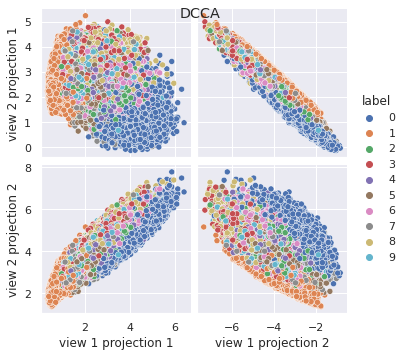

In [ ]:
# Create a CNN
# %%
# Deep CCA
# ----------------------------
encoder_1 = Encoder(latent_dims=LATENT_DIMS)
encoder_2 = Encoder(latent_dims=LATENT_DIMS)
decoder_1 = architectures.Decoder(latent_dims=LATENT_DIMS, feature_size=392)
decoder_2 = architectures.Decoder(latent_dims=LATENT_DIMS, feature_size=392)

dcca = DCCA(latent_dims=LATENT_DIMS, encoders=[encoder_1, encoder_2])
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    enable_checkpointing=False,
    log_every_n_steps=1,
)

trainer.fit(dcca, train_loader, val_loader)
dcca_multiview_result = dcca.transform(train_loader)
pairplot_label(dcca_multiview_result, train_labels, title="DCCA")
plt.show()

# put cluster result with label as a dataset

# CNN/MLP to train the dataset


In [ ]:
len(dcca_multiview_result[0]), len(train_labels)

(17984, 42000)

In [ ]:
# Timeline: 
'''
  Nov.15 Basic experiemnt structure done
  Nov.15 Run all the results and collect data
  Nov.15 Run the baseline
         Exp: 1. Compare to DEEP CORAL/BNM/DAN/DANN
         Exp: 2 *. Compare to CCA/DCCA/DCCAE/SplitAE
         
  Nov.16 - 18
        1. Introduction/Related Works/Experiments/
        2. 
'''